In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
same_df = pd.read_csv('/content/drive/MyDrive/one_hot_same.csv')
int_df = pd.read_csv('/content/drive/MyDrive/one_hot_int.csv')

In [4]:
same_df['Covid19'] = same_df['Covid19'].apply(lambda x: 1 if x else 0)
int_df['Covid19'] = int_df['Covid19'].apply(lambda x: 1 if x else 0)

In [5]:
boolean_columns = [
    "Covid19",
    "US_President_Republican",
    "US_President_Democratic",
    "KR_President_Democratic",
    "KR_President_Conservative",
    "KR_President_Neutral"
]

same_df[boolean_columns] = same_df[boolean_columns].astype(bool)
int_df[boolean_columns] = int_df[boolean_columns].astype(bool)

In [6]:
same_df.set_index('Date', inplace = True)
int_df.set_index('Date', inplace = True)

In [7]:
features = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'SE_Operating_Profit', 'SE_Net_Profit',
            'SE_Total_Equity', 'SE_Total_Liabilities', 'SE_Revenue', 'SE_Foreign', 'US_Inflation', 'KR_Inflation',
            'CN_Inflation', 'US_GDP_Annual', 'KR_GDP_Annual', 'CN_GDP_Annual', 'US_Economic_Growth_Rate',
            'KR_Economic_Growth_Rate', 'US_Base', 'US_10', 'KR_Base', 'KR_10', 'WTI', 'Exchange', 'SOX_Close',
            'Phone', 'KR_Unemployment', 'Covid19', 'US_President_Republican', 'US_President_Democratic',
            'KR_President_Democratic', 'KR_President_Conservative', 'KR_President_Neutral']

target = ['Close']

In [8]:
x_same = same_df[features].values
y_same = same_df[target].values

x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

x_same_scaled = x_scaler.fit_transform(x_same)
y_same_scaled = y_scaler.fit_transform(y_same.reshape(-1, 1))

print(x_same_scaled.shape, y_same_scaled.shape)

(5865, 35) (5865, 1)


In [9]:
x_int = int_df[features].values
y_int = int_df[target].values

x_int_scaled = x_scaler.fit_transform(x_int)
y_int_scaled = y_scaler.fit_transform(y_int.reshape(-1, 1))

print(x_int_scaled.shape, y_int_scaled.shape)

(5865, 35) (5865, 1)


In [17]:
def train_val_test_split(x, y, train_size=0.6, val_size=0.2):
    N = len(x)
    train_len = int(N * train_size)
    val_len = int(N * val_size)
    test_len = N - (train_len + val_len)

    x_train = x[:train_len]
    y_train = y[:train_len]

    x_val = x[train_len:train_len + val_len]
    y_val = y[train_len:train_len + val_len]

    x_test = x[train_len + val_len:]
    y_test = y[train_len + val_len:]

    return x_train, y_train, x_val, y_val, x_test, y_test

x_train_same, y_train_same, x_val_same, y_val_same, x_test_same, y_test_same = train_val_test_split(x_same_scaled, y_same_scaled)
x_train_int, y_train_int, x_val_int, y_val_int, x_test_int, y_test_int = train_val_test_split(x_int_scaled, y_int_scaled)

## X

In [37]:
def create_sequences(x, y, seq_len=30):
    sequences, labels = [], []
    for i in range(len(x) - seq_len):
        sequences.append(x[i:i + seq_len])
        labels.append(y[i + seq_len])
    return np.array(sequences), np.array(labels)

x_same_seq, y_same_seq = create_sequences(x_same_scaled, y_same_scaled)
x_int_seq, y_int_seq = create_sequences(x_int_scaled, y_int_scaled)

In [19]:
def xgboost():
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        alpha=10,
        n_estimators=100
    )
    return model

In [20]:
def train_and_evaluate(x_train, y_train, x_val, y_val):
    model = xgboost()
    model.fit(x_train, y_train)

    #예측
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)

    #RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print(f"Train RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")

    return model

In [21]:
initial_same = train_and_evaluate(x_train_same, y_train_same, x_val_same, y_val_same)

Train RMSE: 0.017487763962789754
Validation RMSE: 0.14830161630756397


In [22]:
initial_int = train_and_evaluate(x_train_int, y_train_int, x_val_int, y_val_int)

Train RMSE: 0.017431709963722543
Validation RMSE: 0.18569169256823212


In [24]:
def tune_hyperparameters(x_train, y_train):
    model = xgboost()

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [100, 200, 300],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'alpha': [0, 10, 20]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(x_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)

    return grid_search.best_estimator_

In [26]:
same_model = tune_hyperparameters(x_train_same, y_train_same)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [27]:
int_model = tune_hyperparameters(x_train_int, y_train_int)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [ ]:
train_and_evaluate(x_train_same, y_train_same, x_val_same, y_val_same)

In [ ]:
train_and_evaluate(x_train_int, y_train_int, x_val_int, y_val_int)

#Wandb

In [10]:
!pip install wandb

In [11]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mkum09 (mkum09-hanyang-university). Use `wandb login --relogin` to force relogin


True

In [12]:
wandb.init(project="timeseries_stock", name="6")

In [13]:
wandb.init(project="Stock Price XGBoost", name="hyper1(xgboost)", config={
    "epochs": 30,
    "batch_size": 32,
    "time_steps": 30,  # XGBoost가 사용하는 시계열 길이 (윈도우 크기)
    "n_estimators": 200,  # XGBoost의 트리 수
    "max_depth": 3,  # 트리의 깊이
    "learning_rate": 0.1,  # 학습률
    "alpha": 0,  # L1 규제
    "colsample_bytree": 0.7,  # 트리에서 사용할 피처 비율
    "optimizer": "adam",
    "loss": "rmse",
})

In [14]:
def create_sequences(x, y, seq_len=30):
    sequences, labels = [], []
    for i in range(len(x) - seq_len):
        sequences.append(x[i:i + seq_len])  # 시계열 길이에 맞춰 슬라이딩 윈도우
        labels.append(y[i + seq_len])  # 타겟은 윈도우 뒤에 있는 값
    return np.array(sequences), np.array(labels)

x_same_seq, y_same_seq = create_sequences(x_same_scaled, y_same_scaled)
x_int_seq, y_int_seq = create_sequences(x_int_scaled, y_int_scaled)

In [15]:
def train_xgboost_model_with_best_params(x_train, y_train, x_val, y_val):
    # 하이퍼파라미터 설정
    params = {
        'alpha': wandb.config.alpha,
        'colsample_bytree': wandb.config.colsample_bytree,
        'learning_rate': wandb.config.learning_rate,
        'max_depth': wandb.config.max_depth,
        'n_estimators': wandb.config.n_estimators
    }

    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # 회귀 문제의 손실 함수
        **params  # 최적 하이퍼파라미터 적용
    )

    model.fit(x_train, y_train)

    # 예측
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)

    # 손실 계산
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    print(f"Train RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")

    # wandb로 로깅: 학습 손실과 RMSE를 기록
    wandb.log({"train_rmse": train_rmse, "val_rmse": val_rmse})

    return model

In [18]:
# same_df
model_same = train_xgboost_model_with_best_params(x_train_same, y_train_same, x_val_same, y_val_same)
# int_df
model_int = train_xgboost_model_with_best_params(x_train_int, y_train_int, x_val_int, y_val_int)

Train RMSE: 0.002238782040094696
Validation RMSE: 0.10423063123643868
Train RMSE: 0.0021985941137265203
Validation RMSE: 0.10447993906962016


In [19]:
def evaluate_model(model, x_test, y_test):
    test_pred = model.predict(x_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    print(f"Test RMSE: {test_rmse}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual")
    plt.plot(test_pred, label="Predicted")
    plt.title("Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

    # WandB에 그래프 로깅
    wandb.log({"Prediction vs Actual Graph": wandb.Image(plt)})

Test RMSE: 0.23426901949185028


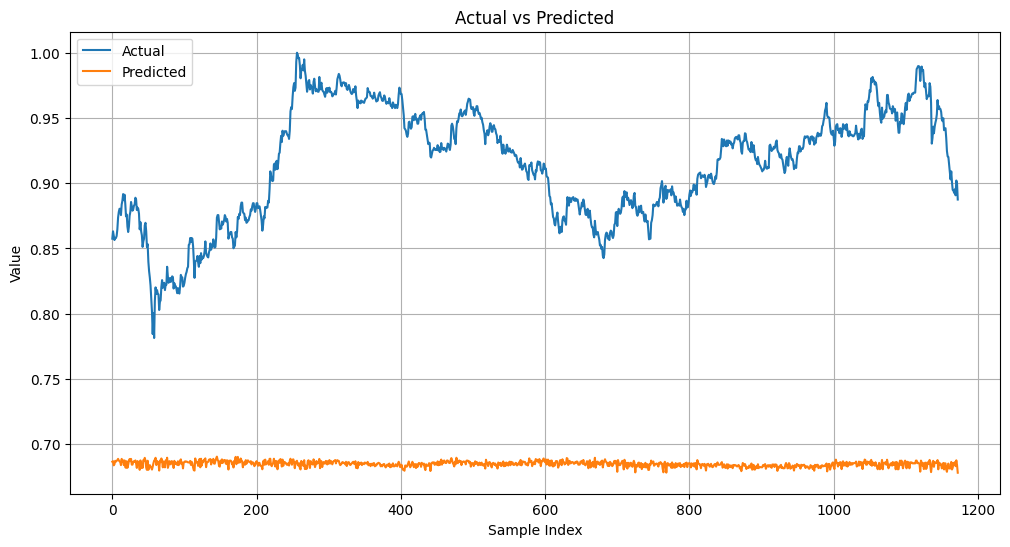

<Figure size 640x480 with 0 Axes>

In [20]:
evaluate_model(model_same, x_test_same, y_test_same)

Test RMSE: 0.23226490539979266


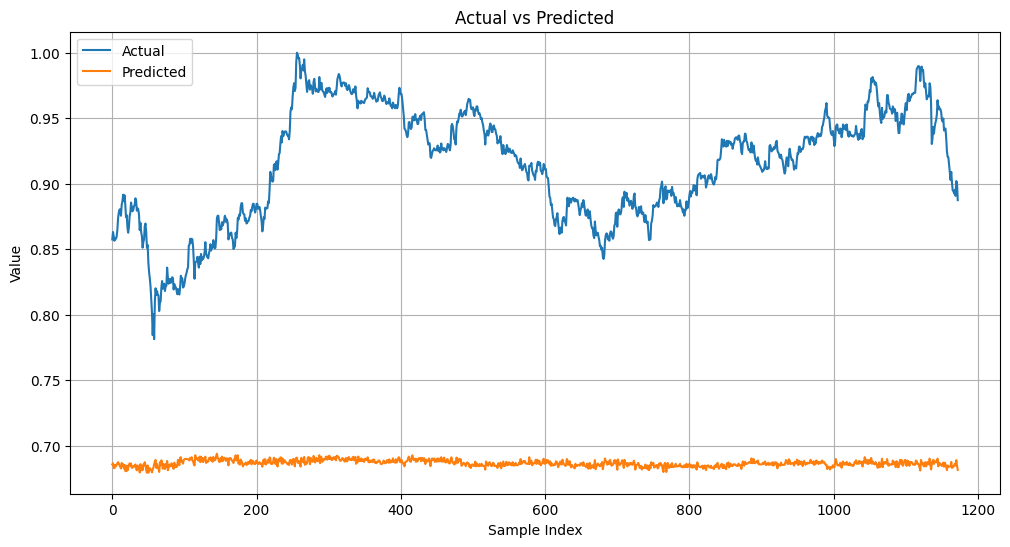

<Figure size 640x480 with 0 Axes>

In [21]:
evaluate_model(model_int, x_test_int, y_test_int)

In [46]:
wandb.save("time_series_model_same.pth")
wandb.save("time_series_model_int.pth")

[]

In [22]:
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'subsample': [0.7, 0.8, 0.9]
}

In [23]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(x_train_same, y_train_same)

print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


In [24]:
best_model = grid_search.best_estimator_

In [25]:
y_pred = best_model.predict(x_test_same)
rmse = np.sqrt(mean_squared_error(y_test_same, y_pred))
print(f"Test RMSE: {rmse}")

# wandb에 성능 로깅
wandb.log({"test_rmse": rmse})

Test RMSE: 0.23299974626623532
